# Homework 4

The due date for this assignment is posted on Canvas. There are 22
points possible (2 for setup, 20 for your answers in the notebook). This
assignment is worth approximately 8% of your final grade.

This assignment can be completed in **groups of two**. If you need to find a
partner, please post in the pinned note on Piazza. To invite your partner to
your group, please go to the "Settings" page on GitHub, and click on
"Collaborators and Access" on the left-hand toolbar. If you are in a repository
named hw4-myusername, then this should bring you to a url like
"https://github.com/cs449f23/hw4-myusername/settings/access." Then, click
"Add people" and add your teammate to your repository. Please give them
"Write," "Maintain," or "Admin" access.

Late work is accepted by editing the `LATE_DAYS` file. See `README.md` for more information.

## Academic Integrity

Once you have formed your groups, the work you submit must belong only to your group members. All group members must contribute to the work submitted; if necessary, we may give group members different grades based on their relative contribution. Do not submit another team's work as your own, and do not allow another team to submit your work as their own.

If you use resources you find online, you must cite those in your notebook. If we find sufficiently suspicious similarities between your answers and those of another group, all students involved may be reported for a suspected violation. If you're unsure of the academic integrity policies, ask for help; we can help you avoid breaking the rules, but we can't un-report a suspected violation.

By pushing your code to GitHub, you agree to these rules, and understand that there may be severe consequences for violating them.

Note: You may reference the LSTM notebooks we provided on Canvas, but you should cite those like any other resource.

## Important instructions

To submit this assignment, you should commit to your GitHub account:

* your Net ID(s) in the netid file; one per line. Please do not put your name in your notebook; we will grade these anonymously.

* a hw4.pdf printout of the completed notebook that shows all your answers.

* your final hw4.ipynb notebook with outputs saved. If we run your notebook from scratch, it should produce an output (almost) identical to your PDF. You can edit your notebook however you want (on Colab, on your local machine, somewhere else); just upload the latest version of it to GitHub.

Your GitHub account must submit contain all three of these, or you will lose points.

In [1]:
# Choose basedir as either local or hosted directory
import os
if "COLAB_BACKEND_VERSION" in os.environ:
    base_dir = "/content"
else:
    base_dir = os.getcwd()

# get helper code from the course repository
# install common packages used for deep learning
%cd $base_dir
!git clone https://github.com/cs449f23/lectures.git lectures/
%cd $base_dir/lectures/
!git pull -q origin main
!pip install -q -r requirements.txt

/content
Cloning into 'lectures'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 222 (delta 103), reused 211 (delta 95), pack-reused 0
Receiving objects: 100% (222/222), 22.61 MiB | 10.45 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/lectures
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import datetime
import math
import torch
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm
import torchvision
import torch.nn as nn

from datasets import load_dataset
from transformers import AutoTokenizer, BertTokenizer

/home/imy7193/.conda/envs/cs449/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----
## <a name="1">Question 1: A Simple Sequence Task (6 points total)</a>

In this question, we'll explore the differences between standard recurrent neural networks (RNNs) and long short-term memory networks (LSTMs) using a simple addition task akin to the one used in the [original LSTM paper](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory).



### __1.1__ RNN vs LSTM (1 point)

__Explain the argument for why we would expect an LSTM to outperform a standard RNN on many problems that involve processing long sequences.__

<center>
<div style="color:red;background-color:#e5e5e5">By using different gates, an LSTM can selectively combine past information with current inputs, thus enabling long-term dependencies. Meanwhile, the gates also reduces the possibility of gradient vanishing and exploding. Both help an LSTM to outperform a standard RNN.</div>
</center>


### __1.2__ LSTM vs Transformer (1 point)

__Explain the argument for why we would expect a Transformer model to outperform a LSTM on many problems that involve processing long sequences.__

<center>
<div style="color:red;background-color:#e5e5e5">By the self-attention mechanism, a Transformer can better address the correlations among different tokens in different positions (i.e., long-term dependencies). The position encoding also provides positional information to the model. Therefore, a Transformer is expected to perform better than an LSTM.</div>
</center>


The following utility code is provided to help with the question. Note that the addition task is formulated as a _classification_ rather than _regression_ problem: because the operands are digits, their sum must be a positive integer in [0, 18], allowing us to output a vector of "class scores" over these potential values.

In [3]:
def MakeItHot(data, num_tokens):
    """ Make the one hot encoding of the input."""
    i_size, j_size = data.shape
    one_hot_data = torch.zeros(i_size, j_size, num_tokens)
    for i in range(0,i_size):
        for j in range(0,j_size):
            one_hot_data[i,j,data[i,j]] = 1

    return one_hot_data

def KeepItCool(data):
    """Just use the data as-is...but with a new dimension added"""
    return torch.unsqueeze(data,2)


class Add2DigitsDataset(torch.utils.data.Dataset):
    """Add2DigitsDataset"""

    def __init__(self, num_examples=3, seq_length=10):
        """Create a set of examples, where each example is a sequence of single
        positive digits (0 through 9) interspersed with 1 instance of a negative
        one. The game is to sum the final digit in the sequence with the
        digit after the -1. The correct label y for the sequence x is the sum of
        these two digits. Here are 3 examples.

        x = [1, -1, 3, 7, 8, 9]
        y = 12

        x = [9, 1, 2, 4, -1, 7, 2, 3, 1, 0]
        y = 7

        x = [9, -1, 9, 2 , 1, 3, 0, 5, 6, 4, 7, 8, 5, 1]
        y = 10


        PARAMETERS
        ----------
        num_examples    A non-negative integer determining how much data we'll generate
        seq_length      A non-negative integer saying how long the sequences all are.

        EXAMPLE USE
        -----------
        dataset = Add2DigitsDataset(num_examples = 100, seq_length = 9)
        data, one_hot_data, labels  = dataset[:]
        print(f'Train instances: one_hot_data (shape {one_hot_data.shape}), labels (shape {labels.shape})')
        loader =  torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
        """

        assert seq_length >= 3, "Seq_length must be a minimum of 3"
        self.seq_length = seq_length
        self.num_tokens = 11

        # make random sequences of integers of the right length
        data = torch.randint(10, (num_examples, seq_length))
        # the labels will go here...
        label = torch.ones(num_examples,1)

        # Now insert our special tokens
        for x in range(0, num_examples):
            # figure out where to place our special token
            a_idx = torch.randint(0, seq_length-2, (1,1)).squeeze()

            # insert the special_tokens
            data[x,[a_idx]] = -1

            # create the label by summing the digit after the special -1 token
            # with the final digit in the sequence
            label[x] = data[x,a_idx+1]+data[x,-1]

        # OK. Store data for later.
        self.data = KeepItCool(data)
        self.one_hot_data = MakeItHot(data, num_tokens=self.num_tokens)
        self.label = label.squeeze().long()
        self.lengths = self.seq_length * torch.ones_like(self.label)
        self.lengths = self.lengths.squeeze().long().tolist()

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.one_hot_data[idx], self.label[idx] #, self.lengths[idx]

# Make sure our dataset looks correct by looking at a few examples...
dataset = Add2DigitsDataset(num_examples=100,seq_length=5)
data, one_hot_data, labels = dataset[:3]
# inputs have shape (B, MAX_L, V) where MAX_L is largest length in batch
print("Data  " + "==" * 10)
print(f"Shape: {data.shape}")
print(data)
print()

print("One-hot Encoding  " + "==" * 10)
print(f"Shape: {one_hot_data.shape}")
print(one_hot_data)
print()
print("Labels  " + "==" * 10)
print(f"Shape: {labels.shape}")
print(labels)

Data  ====================
Shape: torch.Size([3, 5, 1])
tensor([[[ 9],
         [ 4],
         [-1],
         [ 1],
         [ 1]],

        [[-1],
         [ 2],
         [ 0],
         [ 5],
         [ 8]],

        [[ 3],
         [ 6],
         [-1],
         [ 4],
         [ 1]]])

One-hot Encoding  ====================
Shape: torch.Size([3, 5, 11])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 

In [4]:
class MyRNN(torch.nn.Module):
    """
    A simple RNN that that lets you select architectural features when creating
    a new instance
    """

    def __init__(self,
               input_size: int,
               hidden_size: int,
               output_size: int,
               num_layers: int = 1,
               use_LSTM: bool = True):

        super().__init__()

        if use_LSTM:
            self.rnn = torch.nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True)
        else:
            self.rnn = torch.nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True)

        self.out_proj = nn.Linear(hidden_size, output_size)


    def forward(self, x: torch.Tensor):

        # require batched inputs: (B, MAX_L, V)
        # Here b = the batch size, l = sequence length , v = input token size (i.e.
        # the number of positiions in a one-hot-encoding array)
        assert x.ndim == 3
        b, l, v = x.shape

        # built-in PyTorch layer handles loop along sequence dimension,
        # including passing hidden state back each time step. It also
        # handles creating a new initial state for each batch!
        output, hidden = self.rnn(x)

        # for each item in batch, take final output state
        output = output[:,-1,:]

        # apply final linear layer to get predictions
        output = self.out_proj(output)

        return output


# declare the model and try out th untrained model on a sequence
model = MyRNN(
    input_size=11,
    hidden_size= 128,
    output_size=19, # allow outputs in range [0, 18]
    num_layers=2,
    use_LSTM=False)

# you should use `num_token` = 11: ten tokens for the digits, plus the special -1 token
input =  MakeItHot(torch.tensor([[1,2,3,1,5,6,-1,9,3,4,5,0]]), num_tokens=11)
prediction = model(input)
print('My prediction is ', torch.argmax(prediction))

My prediction is  tensor(15)


In [5]:
### Your experiment code goes here
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def train(model, seq_length):
    dataset = Add2DigitsDataset(10000, seq_length)
    train_size = int(0.8*len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

    loss_func = torch.nn.CrossEntropyLoss()
    model_opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 20
    losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        total_loss = []
        total_acc = []
        for (data, one_hot_data, labels) in train_loader:
            model_opt.zero_grad()
            y = labels
            logits = model(one_hot_data)
            loss = loss_func(logits, y.squeeze())
            pred = torch.argmax(logits, dim=1, keepdims=True).squeeze()
            acc = pred == y
            acc = torch.mean(acc.float())
            loss.backward()
            model_opt.step()

            total_loss.append(loss.detach().numpy())
            total_acc.append(acc.detach().numpy())

        losses.append(np.mean(total_loss))
        train_accs.append(np.mean(total_acc))

        if (epoch + 1) % max(1, num_epochs // 10) == 0:
            model.eval()
            with torch.no_grad():
                total_acc = []
                for (data, one_hot_data, labels) in val_loader:
                    y = labels
                    logits = model(one_hot_data)
                    pred = torch.argmax(logits, dim=1, keepdims=True).squeeze()
                    acc = pred == y
                    acc = torch.mean(acc.float())
                    total_acc.append(acc.detach().numpy())
                val_accs.append(np.mean(total_acc))
            model.train()

    return losses, train_accs, val_accs

seq_lengths = [5, 10, 30]
rnn_losses = {}
rnn_train_accs = {}
rnn_val_accs = {}
lstm_losses = {}
lstm_train_accs = {}
lstm_val_accs = {}
for i in range(3):

    rnn_model = MyRNN(
      input_size=11,
      hidden_size= 128,
      output_size=19, # allow outputs in range [0, 18]
      num_layers=2,
      use_LSTM=False)

    lstm_model = MyRNN(
      input_size=11,
      hidden_size= 128,
      output_size=19, # allow outputs in range [0, 18]
      num_layers=2,
      use_LSTM=True)

    rnn_losses[i], rnn_train_accs[i], rnn_val_accs[i] = train(rnn_model, seq_lengths[i])
    lstm_losses[i], lstm_train_accs[i], lstm_val_accs[i] = train(lstm_model, seq_lengths[i])

### __1.3__ Empirical Comparison (2 points)

Use the code provided above to compare the performance of a standard RNN to an LSTM on the task defined by the `Add2DigitsDataset`. Do this for three different lengths of sequence (5, 10, and 30). For all experiments, use a hidden size of 128 and 2 layers. Keep your network architecture the same, except for the substitution of the LSTM for an RNN. Provide the following graphs __for each sequence length__:

  1. __Loss as a function of the number of training steps__  
  2. __Training accuracy & validation accuracy as a function of the number of training steps.__

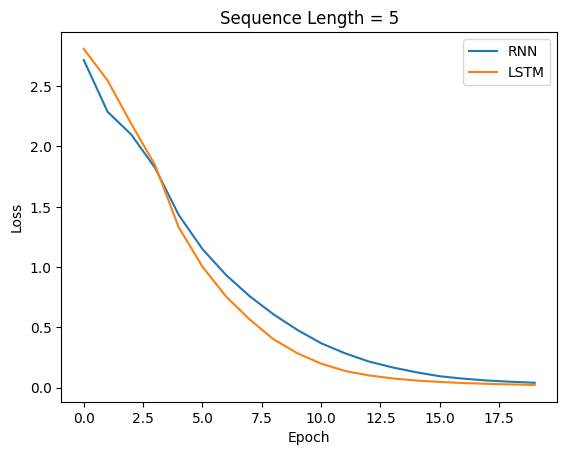

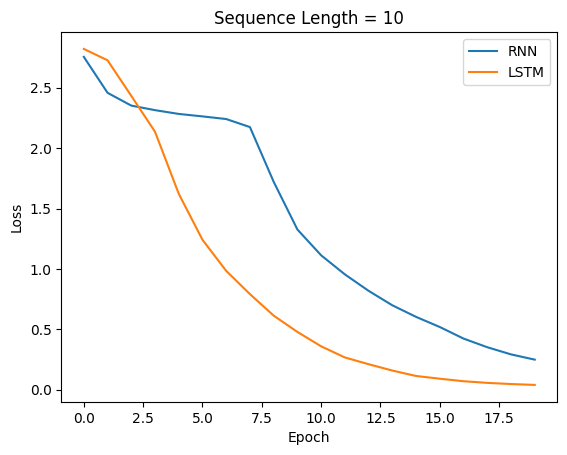

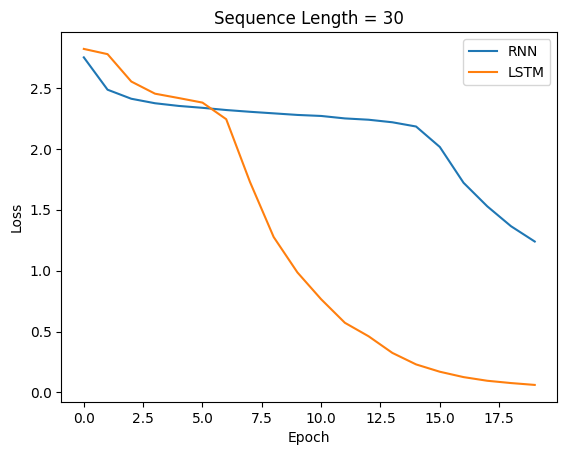

In [6]:
for i in range(3):
    plt.figure()
    plt.plot(rnn_losses[i], label='RNN')
    plt.plot(lstm_losses[i], label='LSTM')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Sequence Length = '+str(seq_lengths[i]))
    plt.show()

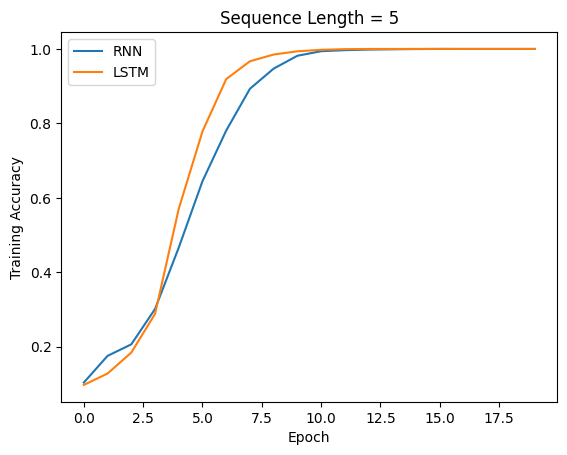

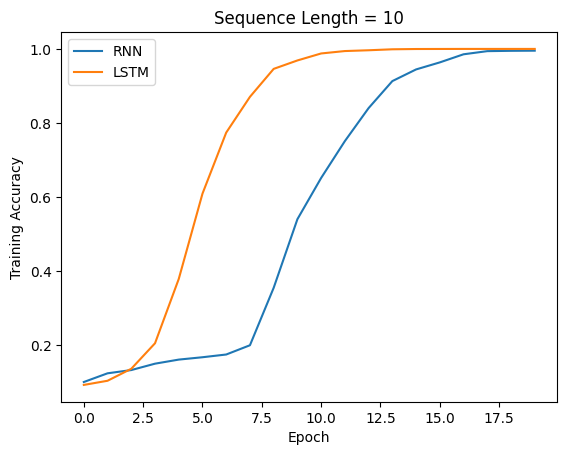

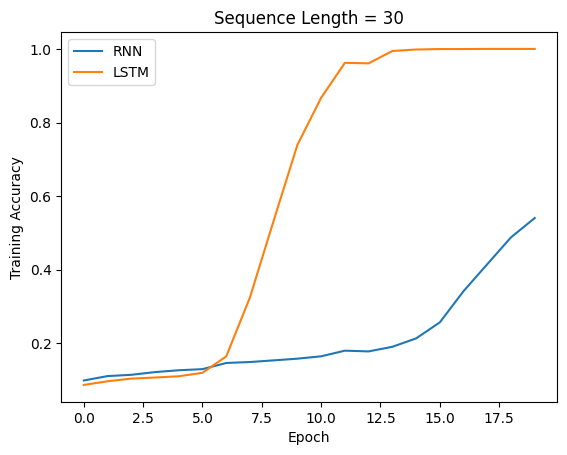

In [7]:
for i in range(3):
    plt.figure()
    plt.plot(rnn_train_accs[i], label='RNN')
    plt.plot(lstm_train_accs[i], label='LSTM')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.title('Sequence Length = '+str(seq_lengths[i]))
    plt.show()

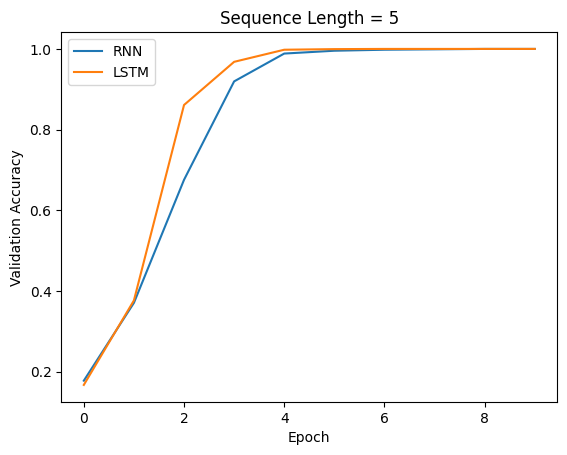

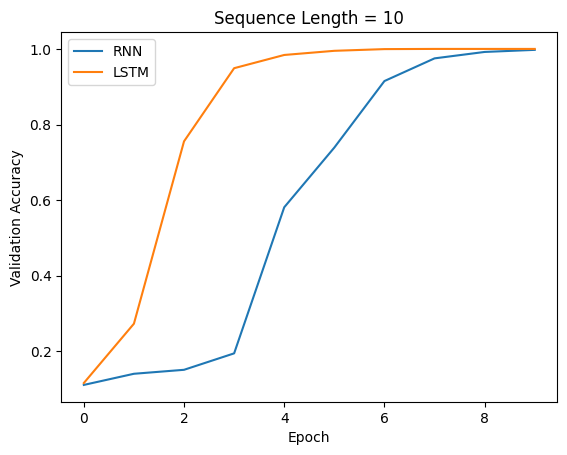

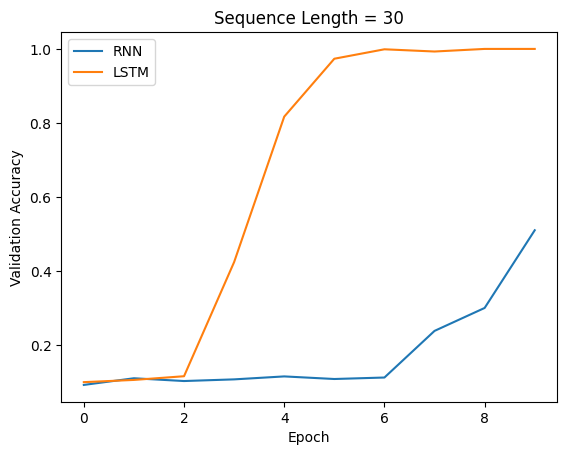

In [8]:
for i in range(3):
    plt.figure()
    plt.plot(rnn_val_accs[i], label='RNN')
    plt.plot(lstm_val_accs[i], label='LSTM')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Sequence Length = '+str(seq_lengths[i]))
    plt.show()

### __1.4__ Analysis (2 point)

Provide your analysis of the above experiment from Question 1.3. Make sure to mention:
- Was the hypothesis from question 1.1 supported by your data? Why or why not?
- What might be the limitations of your experiment? How would you improve it?

<center>
<div style="color:red;background-color:#e5e5e5">

Yes. The hypothesis was supported by the data. Both the losses and accuracies of the LSTM converges faster and better than that of the RNN.

The results may rely on the number of inputs, the difficulty of the task. More various tasks and experiments should be conducted to verify the hypothesis.
</div>
</center>


----
## <a name="2">Question 2: Sequence-to-Sequence Translation (10 points total)</a>

Sequence-to-sequence tasks such as language translation require a model capable of converting variable-length inputs to variable-length outputs, with no guarantee that each position in the input will map directly to a position in the output. This can be thought of as a "many-to-many" task, as illustrated by the second figure from the right in Andrej Karpathy's diagram:

<br/>
<center>
<img width="600px" src="https://raw.githubusercontent.com/cs449s23/lectures/main/static/hw4_rnns.jpeg" />
</center>
<br/>

<p>
<center>
Image source: "The Unreasonable Effectiveness of Recurrent Neural Networks" (Karpathy)
</center>
</p>

For example, consider the following English-to-Spanish translation:

`I like chocolate` --> `Me gusta el chocolate`

The input sequence contains three words, while the output sequence contains four. Moreover, the individual words and grammatical structure of the sentences do not cleanly correspond, as `chocolate` is preceded by the definite article `el` and the subject switches from the speaker to the chocolate. It's easy to see why sequence-to-sequence translation can be a challenging task!

To overcome these difficulties, [Sutskever et al.](https://arxiv.org/pdf/1409.3215.pdf) proposed to use recurrent __encoder__ and __decoder__ networks. First, special __start and stop tokens__ are added to the ends of all sentences. Then, the encoder RNN loops over an input sequence, and its final hidden state is taken as a representation of the entire input "context." This context is passed to the decoder RNN, which generates one word at a time __autoregressively__ (taking its own past predictions as inputs) until it produces a stop token. This allows for arbitrary input and output lengths, as (a) the only representation of the input that the decoder sees is a single context vector, and (b) the decoder is free to generate for as long as it wants to before emitting a stop token.

<br/>
<center>
<img width="600px" src="https://raw.githubusercontent.com/cs449s23/lectures/main/static/hw4_sutskever.png" />
</center>
<br/>

<p>
<center>
Image source: "Sequence to Sequence Learning with Neural Networks" (Sutskever et al. 2014). "EOS" is the end-of-sentence stop token.
</center>
</p>

In this question, we'll explore how to use the encoder-decoder architecture to perform Turkish-to-English translation. This will require a bit of setup, which is documented in the next section. To simplify the process and avoid messing with your local Python environment, it's recommended that you use [Google Colab](https://colab.research.google.com/).

Part of this notebook was adapted from a tutorial by Ben Trevett.

In [3]:
# Download 1000 training examples and 100 test examples
# for a Turkish <-> English translation dataset

train_dataset = load_dataset("wmt16", "tr-en", split="train[:1000]")
test_dataset = load_dataset("wmt16", "tr-en", split="test[:100]")

tr_tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
print(f"Turkish vocab size: {tr_tokenizer.vocab_size}")
en_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
print(f"English vocab size: {en_tokenizer.vocab_size}")

Turkish vocab size: 32000
English vocab size: 28996


In [4]:
# Show an example and the tokenization of the text

example = next(iter(train_dataset))["translation"]
print("# Turkish")
print(example["tr"])
print(tr_tokenizer(example["tr"])["input_ids"])
print(tr_tokenizer.decode(tr_tokenizer(example["tr"])["input_ids"]))

print("\n# English")
print(example["en"])
print(en_tokenizer(example["en"])["input_ids"])
print(en_tokenizer.decode(en_tokenizer(example["en"])["input_ids"]))

# Turkish
Kosova'nın özelleştirme süreci büyüteç altında
[2, 9868, 11, 2732, 20539, 6607, 9734, 2100, 3282, 3]
[CLS] Kosova'nın özelleştirme süreci büyüteç altında [SEP]

# English
Kosovo's privatisation process is under scrutiny
[101, 11494, 112, 188, 185, 2047, 26465, 5771, 1965, 1110, 1223, 19258, 102]
[CLS] Kosovo's privatisation process is under scrutiny [SEP]


In [5]:
# Preprocess and batch our datasets
# Here, we are fixing sequences to be no longer than 20 tokens,
#   which is a substantial limitation. However, it makes things faster.
MAX_LENGTH = 20

from torch.utils.data import DataLoader, Subset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tokenize(example):
    pair = example["translation"]
    tr_tokens = tr_tokenizer(pair["tr"])["input_ids"][:MAX_LENGTH]
    en_tokens = en_tokenizer(pair["en"])["input_ids"][:MAX_LENGTH]
    retval = {"tr_tokens": tr_tokens, "en_tokens": en_tokens}

    return retval

def collate(batch):
    tr_tokens = [torch.Tensor(x["tr_tokens"]).long().to(device) for x in batch]
    tr_batch = torch.nn.utils.rnn.pad_sequence(tr_tokens, batch_first=True,)

    en_tokens = [torch.Tensor(x["en_tokens"]).long().to(device) for x in batch]
    en_batch = torch.nn.utils.rnn.pad_sequence(en_tokens, batch_first=True)

    return (tr_batch, en_batch)

tokenized_train = train_dataset.map(tokenize)
batched_train = DataLoader(tokenized_train, batch_size=64,
                           drop_last=False, collate_fn=collate)
tokenized_test = test_dataset.map(tokenize)
batched_test = DataLoader(tokenized_test, batch_size=64,
                           drop_last=False, collate_fn=collate)

In [6]:
# Print out some (padded, batched) examples
for example in batched_train:
    src, trg = example
    print(src[:5, :])
    print(trg[:5, :])
    break

tensor([[    2,  9868,    11,  2732, 20539,  6607,  9734,  2100,  3282,     3,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    2,  9868,    16,  3404,  2720,  6329,  1990, 15000, 20539, 12799,
         23355,  4063,    18,     3,     0,     0,     0,     0,     0,     0],
        [    2, 24955, 20169, 12153,  2058,  6903, 26802,  2049,    11,  2350,
          6668,  1994, 23810,  1032,  1026,  6968,    11,  2491,  8173,    17],
        [    2,  6654,  4655,  1983,  4239,  2180,  2478, 12885,  7627,  1992,
          7911, 11604,  5584,  3617,    16,  7045,  8277,  2696,  3609, 11639],
        [    2,  2654,  6847,  7845,  2961,    16,  5412,  1996,  4895,  2200,
          6372,    18,     3,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')
tensor([[  101, 11494,   112,   188,   185,  2047, 26465,  5771,  1965,  1110,
          1223, 19258,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101, 11494

# __2.1__ RNN Translation (3 points)

Finally, we can train an encoder-decoder model to perform sequence-to-sequence translation.

Modify the definitions in the cell below as instructed by the accompanying comments. Then, run the following cell to train and evaluate your encoder-decoder network for Turkish-to-English translation. Finally, include a plot of your training and validation losses by epoch where instructed below.

__Hints__:
1. If your implementation is "correct," you should see your loss decrease as your model trains. You can also check your implementation by running the example translation provided after the training code.

1. When you're initially trying to get your code to run, don't worry about whether the model outputs "the" over and over again or has other silly behaviors.

1. We are limiting the sentence length to `MAX_LENGTH=20` tokens (not 20 words), so the sentences you see in your output may be shorter than you expect.

1. __It may take ~500 epochs for the model to fully learn the training data!__

In [7]:
class RNNEncoder(torch.nn.Module):

    def __init__(self,
                 input_size: int,
                 embedding_size: int,
                 hidden_size: int,
                 depth: int,
                 dropout: float):

        super().__init__()

        self.hidden_size = hidden_size
        self.depth = depth

        # embedding layer: similar to one-hot encoding, we will map
        # integer indices to vectors
        self.embedding = torch.nn.Embedding(input_size, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (1/5)
        ###########################################################
        self.rnn = nn.RNN(
                input_size=embedding_size,
                hidden_size=hidden_size,
                num_layers=depth,
                batch_first=True)
        ###########################################################
        # YOUR CODE ENDS HERE (1/5)
        ###########################################################

        # a dropout layer can improve generalization
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        """
        Forward pass of the encoder RNN.
        Input x: source sentence (e.g., in Turkish)
        Returns: final hidden state of the RNN
        """

        assert x.ndim == 2
        batch_size, seq_len = x.shape

        # convert integer indices to vector representations
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq_len, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (2/5)
        ###########################################################
        output, hidden = self.rnn(embedded)
        return hidden
        ###########################################################
        # YOUR CODE ENDS HERE (2/5)
        ###########################################################

class RNNDecoder(torch.nn.Module):

    def __init__(self,
                 output_size: int,
                 embedding_size: int,
                 hidden_size: int,
                 depth: int,
                 dropout: float):

        super().__init__()

        self.hidden_size = hidden_size
        self.depth = depth
        self.output_size = output_size

        # embedding layer: similar to one-hot encoding, we will map
        # integer indices to vectors
        self.embedding = torch.nn.Embedding(output_size, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (3/5)
        ###########################################################
        self.rnn = nn.RNN(
                input_size=embedding_size,
                hidden_size=hidden_size,
                num_layers=depth,
                batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        ###########################################################
        # YOUR CODE ENDS HERE (3/5)
        ###########################################################

        # a dropout layer can improve generalization
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, hidden: torch.Tensor):
        """
        Forward pass of the decoder RNN.
        Input x: target sentence input (e.g., in English)
        Returns: prediction for next token, and final hidden state of RNN
        """

        # take a single time-step of input and a single hidden state
        if x.ndim == 1:
            x = x.unsqueeze(1)
        batch_size, _ = x.shape

        # convert integer indices to vector representations
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (4/5)
        ###########################################################
        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output.squeeze())
        return output, hidden
        ###########################################################
        # YOUR CODE ENDS HERE (4/5)
        ###########################################################


class RNNTranslator(torch.nn.Module):
    def __init__(self,
                 encoder: torch.nn.Module,
                 decoder: torch.nn.Module,
                 device):

        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
        f"Mismatch: `encoder.hidden_size` = {encoder.hidden_size}, `decoder.hidden_size` = {decoder.hidden_size}"

        assert encoder.depth == decoder.depth, \
        f"Mismatch: `encoder.depth` = {encoder.depth}, `decoder.depth` = {decoder.depth}"

    def forward(self, x: torch.Tensor, y: torch.Tensor, teacher_forcing_ratio: float = 0.5):
        """
        Translate a sentence from source (e.g., Turkish) to target (e.g., English)
        """

        # inputs should have shape (batch_size, in_seq_len)
        assert x.ndim == 2
        batch_size, in_seq_len = x.shape

        # targets should have shape (batch size, out_seq_len,)
        assert y.ndim == 2
        _, out_seq_len = y.shape
        out_vocab_size = self.decoder.output_size

        # prepare to store decoder outputs. We only need to allocate
        # the "true" number of time steps during training, but for inference
        # we can simply pass in an empty `y` of any length; this will serve as
        # a maximum length constraint on the output translation (which may end
        # sooner if an <EOS> token is predicted).
        outputs = []

        ###########################################################
        # YOUR CODE STARTS HERE (5/5)
        ###########################################################
        hidden = self.encoder(x)
        ###########################################################
        # YOUR CODE ENDS HERE (5/5)
        ###########################################################

        # first input to the decoder is the <SOS> start token
        input = y[:,:1]

        for t in range(1, out_seq_len):

            # given input for current time step (either previous decoder
            # prediction or <SOS> token) and previous hidden state, compute
            # new output and hidden states
            output, hidden = self.decoder(input, hidden)

            # write predicted word probabilities to output buffer
            outputs.append(output)

            # during training, we may randomly decide whether to use
            # the decoder's previous predictions or the ground-truth
            # tokens for the previous time step. When we do the latter,
            # it is called "teacher-forcing." We will randomly apply
            # teacher-forcing during training only.
            teacher_force = random.random() < teacher_forcing_ratio

            # take highest-scoring token from decoder's previous prediction
            top1 = output.argmax(1).unsqueeze(1)

            # optionally apply teacher-forcing
            input = y[:, t] if teacher_force else top1

        outputs = torch.stack(outputs, axis=1).to(self.device)
        return outputs

# 2.2 LSTM Translation (2 points)

The following code (almost) implements an LSTM variation on the RNN translator you implemented above.
Until you have your RNNTranslator class (above) running with the experimental code (below), you should skip this cell.

In [8]:
class LSTMEncoder(torch.nn.Module):

    def __init__(self,
                 input_size: int,
                 embedding_size: int,
                 hidden_size: int,
                 depth: int,
                 dropout: float):

        super().__init__()

        self.hidden_size = hidden_size
        self.depth = depth

        # embedding layer: similar to one-hot encoding, we will map
        # integer indices to vectors
        self.embedding = torch.nn.Embedding(input_size, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (1/5)
        ###########################################################
        self.lstm = nn.LSTM(
                input_size=embedding_size,
                hidden_size=hidden_size,
                num_layers=depth,
                batch_first=True)
        ###########################################################
        # YOUR CODE ENDS HERE (1/5)
        ###########################################################

        # a dropout layer can improve generalization
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        """
        Forward pass of the encoder RNN.
        Input x: source sentence (e.g., in Turkish)
        Returns: final hidden state of the RNN
        """

        assert x.ndim == 2
        batch_size, seq_len = x.shape

        # convert integer indices to vector representations
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq_len, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (2/5)
        ###########################################################
        output, (hidden, cell) = self.lstm(embedded)
        return hidden, cell
        ###########################################################
        # YOUR CODE ENDS HERE (2/5)
        ###########################################################


class LSTMDecoder(torch.nn.Module):

    def __init__(self,
                 output_size: int,
                 embedding_size: int,
                 hidden_size: int,
                 depth: int,
                 dropout: float,):

        super().__init__()

        self.hidden_size = hidden_size
        self.depth = depth
        self.output_size = output_size

        # embedding layer: similar to one-hot encoding, we will map
        # integer indices to vectors
        self.embedding = torch.nn.Embedding(output_size, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (3/5)
        ###########################################################
        self.lstm = nn.LSTM(
                input_size=embedding_size,
                hidden_size=hidden_size,
                num_layers=depth,
                batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        ###########################################################
        # YOUR CODE ENDS HERE (3/5)
        ###########################################################

        # a dropout layer can improve generalization
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor):
        """
        Forward pass of the decoder RNN.
        Input x: target sentence input (e.g., in English)
        Returns: prediction for next token, and final hidden state of RNN
        """

        # take a single time-step of input, a single hidden state, and a single cell state
        if x.ndim == 1:
            x = x.unsqueeze(1)
        batch_size, _ = x.shape

        # convert integer indices to vector representations
        embedded = self.dropout(self.embedding(x))  # (batch_size, 1, embedding_size)

        ###########################################################
        # YOUR CODE STARTS HERE (4/5)
        ###########################################################
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        output = self.fc(output.squeeze())
        return output, hidden, cell
        ###########################################################
        # YOUR CODE ENDS HERE (4/5)
        ###########################################################


class LSTMTranslator(torch.nn.Module):

    def __init__(self,
                 encoder: torch.nn.Module,
                 decoder: torch.nn.Module,
                 device: str):

        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
        f"Mismatch: `encoder.hidden_size` = {encoder.hidden_size}, `decoder.hidden_size` = {decoder.hidden_size}"

        assert encoder.depth == decoder.depth, \
        f"Mismatch: `encoder.depth` = {encoder.depth}, `decoder.depth` = {decoder.depth}"

    def forward(self, x: torch.Tensor, y: torch.Tensor, teacher_forcing_ratio: float = 0.5):
        """
        Translate a sentence from source (e.g., Turkish) to target (e.g., English)
        """
        # inputs should have shape (batch_size, in_seq_len)
        assert x.ndim == 2
        batch_size, in_seq_len = x.shape

        # targets should have shape (batch size, out_seq_len,)
        assert y.ndim == 2
        _, out_seq_len = y.shape
        out_vocab_size = self.decoder.output_size

        # prepare to store decoder outputs. We only need to allocate
        # the "true" number of time steps during training, but for inference
        # we can simply pass in an empty `y` of any length; this will serve as
        # a maximum length constraint on the output translation (which may end
        # sooner if an <EOS> token is predicted).
        outputs = []

        ###########################################################
        # YOUR CODE STARTS HERE (5/5)
        ###########################################################
        hidden, cell = self.encoder(x)
        ###########################################################
        # YOUR CODE ENDS HERE (5/5)
        ###########################################################

        # first input to the decoder is the <SOS> start token
        input = y[:,:1]
        for t in range(1, out_seq_len):

            # given input for current time step (either previous decoder
            # prediction or <SOS> token) and previous hidden state and
            # cell state, compute new output, hidden, and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            # save predicted word probabilities
            outputs.append(output)

            # during training, we may randomly decide whether to use
            # the decoder's previous predictions or the ground-truth
            # tokens for the previous time step. When we do the latter,
            # it is called "teacher-forcing." We will randomly apply
            # teacher-forcing during training only.
            teacher_force = random.random() < teacher_forcing_ratio

            # take highest-scoring token from decoder's previous prediction
            top1 = output.argmax(1).unsqueeze(1)

            # optionally apply teacher-forcing
            input = y[:, t] if teacher_force else top1

        outputs = torch.stack(outputs, axis=1).to(self.device)
        return outputs

# 2.3 Translation experiments (5 points total)

For either the RNN or the LSTM, you will use the same experimental code below. The hyperparameter values we've given you are ones that worked for us, but you are welcome to change them. You shouldn't need to change any training code below the line that says "Don't change code below this line."

As you run experiments, keep track of what hyperparameters you're using and how the model trains. Are you able to learn anything? Does your model overfit? You'll answer these below.

The model has 32,329,028 trainable parameters
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
patience Newcastleleashed satisfaction orbitwrightogistXTzled স rejectsller spot con assaultĆ spot straw coordinating
Epoch: 01 | Time: 0m 1s
	Train Loss: 8.522
	 Val. Loss: 7.998
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The's new to the a to for the the, of the the to to the the
Epoch: 50 | Time: 0m 37s
	Train Loss: 4.761
	 Val. Loss: 9.893
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The's waterrivatisation process is under scrutiny [SEP]ke ; enhancing judicial voted to favour
Epoch: 100 | Time: 0m 36s
	Train Loss: 1.772
	 Val. Loss: 12.092
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Theimes : You far inisation process is under scrutiny [SEP].. [SEP] [SEP]...
Epoch: 150 | Time: 0m 39s


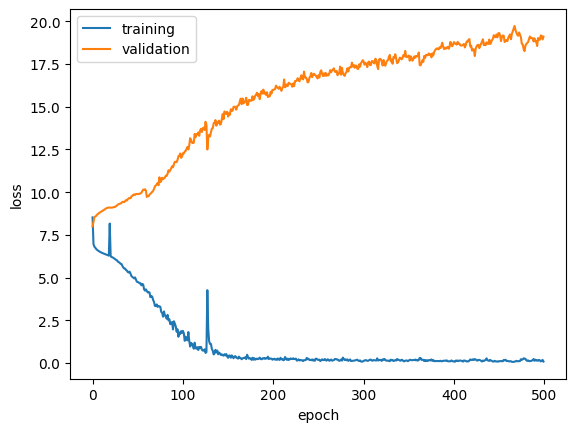

In [8]:
# Training hyperparameters; you are welcome to change these.
# In my experiments, it can take ~500 epochs over the dataset
#   of 1000 training examples before it perfectly
#   translates the training examples.

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 500
CLIP = 1
LR = 0.001
USE_LSTM = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###  Don't change code below this line
###  =================================

INPUT_DIM = tr_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
TRG_PAD_IDX = 0

# initialize encoder-decoder model
if USE_LSTM:
    enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = LSTMTranslator(enc, dec, device)
else:
    enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = RNNTranslator(enc, dec, device)

# initialize model weights
def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

# parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

# optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# track training and validation losses
training_loss = []
validation_loss = []

def train(model, iterator, optimizer, criterion, clip, verbose=False):

    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):

        (src, trg) = batch

        optimizer.zero_grad()
        output = model(src, trg)

        # Every so often, print out how well we're doing.
        if verbose and i == 0:
            print(en_tokenizer.decode(trg[0, 1:]))
            en_tokens = output[0, :, :].argmax(1)
            print(en_tokenizer.decode(en_tokens))

        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            (src, trg) = batch

            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]

            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

start_time = time.time()
for epoch in range(N_EPOCHS):

    verbose = (epoch == 0 or N_EPOCHS <= 10
               or (epoch + 1) % (N_EPOCHS // 10) == 0)

    train_loss = train(model, batched_train, optimizer,
                       criterion, CLIP, verbose=verbose)
    valid_loss = evaluate(model, batched_test, criterion)

    training_loss.append(train_loss)
    validation_loss.append(valid_loss)

    # Every so often, print some details on how we're doing.
    if verbose:
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        start_time = time.time()

# At the end, enerate loss plot
import matplotlib.pyplot as plt
plt.plot(training_loss, label="training")
plt.plot(validation_loss, label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

The model has 37,846,340 trainable parameters
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
##uant Sidney endured endured Birdsrable disturbedrable Birds Birdsrablerablerable Birds Birds Birds Birdsrumprump
Epoch: 01 | Time: 0m 0s
	Train Loss: 8.683
	 Val. Loss: 7.932
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
" The s newrist,, - to the the, " the,, the, the
Epoch: 50 | Time: 0m 45s
	Train Loss: 4.994
	 Val. Loss: 9.672
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Kosovo's authorityrivatisation process on Kosovo scrutiny [SEP] [SEP] is supplement the cease - fire
Epoch: 100 | Time: 0m 45s
	Train Loss: 2.405
	 Val. Loss: 11.589
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Kosovo's privatisation process is under scrutiny [SEP] [SEP] ] is ] [SEP] and those
Epoch: 150 | Time: 0m 42s
	

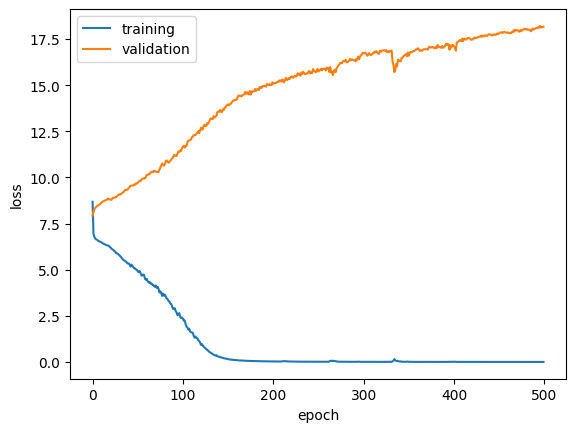

In [9]:
# Training hyperparameters; you are welcome to change these.
# In my experiments, it can take ~500 epochs over the dataset
#   of 1000 training examples before it perfectly
#   translates the training examples.

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 500
CLIP = 1
LR = 0.001
USE_LSTM = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###  Don't change code below this line
###  =================================

INPUT_DIM = tr_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
TRG_PAD_IDX = 0

# initialize encoder-decoder model
if USE_LSTM:
    enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = LSTMTranslator(enc, dec, device)
else:
    enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = RNNTranslator(enc, dec, device)

# initialize model weights
def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

# parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

# optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# track training and validation losses
training_loss = []
validation_loss = []

def train(model, iterator, optimizer, criterion, clip, verbose=False):

    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):

        (src, trg) = batch

        optimizer.zero_grad()
        output = model(src, trg)

        # Every so often, print out how well we're doing.
        if verbose and i == 0:
            print(en_tokenizer.decode(trg[0, 1:]))
            en_tokens = output[0, :, :].argmax(1)
            print(en_tokenizer.decode(en_tokens))

        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            (src, trg) = batch

            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]

            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

start_time = time.time()
for epoch in range(N_EPOCHS):

    verbose = (epoch == 0 or N_EPOCHS <= 10
               or (epoch + 1) % (N_EPOCHS // 10) == 0)

    train_loss = train(model, batched_train, optimizer,
                       criterion, CLIP, verbose=verbose)
    valid_loss = evaluate(model, batched_test, criterion)

    training_loss.append(train_loss)
    validation_loss.append(valid_loss)

    # Every so often, print some details on how we're doing.
    if verbose:
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        start_time = time.time()

# At the end, enerate loss plot
import matplotlib.pyplot as plt
plt.plot(training_loss, label="training")
plt.plot(validation_loss, label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

If you want to explore how sensitive the model is to small changes in the input, you can translate things into Turkish using Google Translate and then see how they are affected here.

In [43]:
# sentence = "Kosova'nın özelleştirme süreci büyüteç altında"

# tokens = tr_tokenizer(sentence)["input_ids"]
# tokens = torch.tensor([tokens]).long().to(device)
# print(tokens)
# dummy_output = torch.ones([1, MAX_LENGTH]).long().to(device)
# model.load_state_dict(torch.load('lstm_model.pt'))
# with torch.no_grad():
#     output = model(tokens, dummy_output, 0).cpu()
#     en_tokens = output[0, :, :].argmax(1)
#     print(en_tokenizer.decode(en_tokens))
sentence = "Kosova'nın özelleştirme süreci büyüteç altında"

tokens = tr_tokenizer(sentence)["input_ids"]
tokens = torch.tensor([tokens]).long().to(device)
tokens = torch.cat((tokens, tokens), dim=0)
print(tokens)
dummy_output = torch.ones([2, MAX_LENGTH]).long().to(device)
model.load_state_dict(torch.load('lstm_model.pt'))
with torch.no_grad():
    output = model(tokens, dummy_output, 0).cpu()
    en_tokens = output[0, :, :].argmax(1)
    print(en_tokenizer.decode(en_tokens))

tensor([[    2,  9868,    11,  2732, 20539,  6607,  9734,  2100,  3282,     3],
        [    2,  9868,    11,  2732, 20539,  6607,  9734,  2100,  3282,     3]],
       device='cuda:0')
enterprises employ [SEP] EU, in those on Wednesday ( July 26th ) in those in the United States


## 2.3.1 Experimental Results (5 points)

Write at least five sentences about what you noticed during your experiments. Include at least two plots of successful training curves over time. Make sure to mention:

- What hyperparameters had the most effect on your model's ability to reduce the *training* loss?
- What about for the *validation* loss?
- What was necessary to prevent underfitting?
- What were you able to do to prevent overfitting?

Both RNN and LSTM are easy to overfit. For reducing training loss, enough dimensions in the model and a good learning rate are important. To reduce the validation loss, the dimensions and the learning rate cannot be too large, otherwise, the validation loss will increase despite the decrease in training loss. Enough dimensions in the model can prevent underfitting. Limiting the dimensions in the model and using a small learning rate can help prevent overfitting a little bit.

The model has 15,720,260 trainable parameters
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
voltage Regarding [unused4]upon Meridian Meridian दkura Meridianrem physiological keeps physiologicaltudefillremremremtude
Epoch: 01 | Time: 0m 0s
	Train Loss: 8.884
	 Val. Loss: 7.852
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The the, the the the the the, the the [SEP] the, the the the the the
Epoch: 50 | Time: 0m 56s
	Train Loss: 6.176
	 Val. Loss: 9.050
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The, s theic a joints of the and,, the and, " the,
Epoch: 100 | Time: 0m 54s
	Train Loss: 5.086
	 Val. Loss: 9.574
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The's :rivatisationlou, the the, of in to the the in "
Epoch: 150 | Time: 0m 55s
	Train Loss: 3.724
	 Val. Loss: 10.677
Kosovo's priva

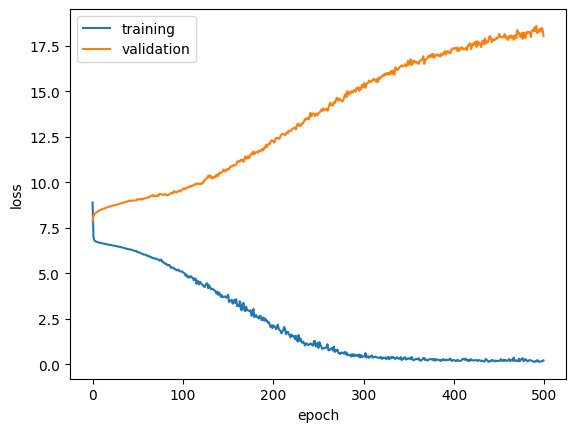

In [ ]:
# Training hyperparameters; you are welcome to change these.
# In my experiments, it can take ~500 epochs over the dataset
#   of 1000 training examples before it perfectly
#   translates the training examples.

ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 500
CLIP = 1
LR = 0.001
USE_LSTM = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###  Don't change code below this line
###  =================================

INPUT_DIM = tr_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
TRG_PAD_IDX = 0

# initialize encoder-decoder model
if USE_LSTM:
    enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = LSTMTranslator(enc, dec, device)
else:
    enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = RNNTranslator(enc, dec, device)

# initialize model weights
def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

# parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

# optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# track training and validation losses
training_loss = []
validation_loss = []

def train(model, iterator, optimizer, criterion, clip, verbose=False):

    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):

        (src, trg) = batch

        optimizer.zero_grad()
        output = model(src, trg)

        # Every so often, print out how well we're doing.
        if verbose and i == 0:
            print(en_tokenizer.decode(trg[0, 1:]))
            en_tokens = output[0, :, :].argmax(1)
            print(en_tokenizer.decode(en_tokens))

        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            (src, trg) = batch

            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]

            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

start_time = time.time()
for epoch in range(N_EPOCHS):

    verbose = (epoch == 0 or N_EPOCHS <= 10
               or (epoch + 1) % (N_EPOCHS // 10) == 0)

    train_loss = train(model, batched_train, optimizer,
                       criterion, CLIP, verbose=verbose)
    valid_loss = evaluate(model, batched_test, criterion)

    training_loss.append(train_loss)
    validation_loss.append(valid_loss)

    # Every so often, print some details on how we're doing.
    if verbose:
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        start_time = time.time()

# At the end, enerate loss plot
import matplotlib.pyplot as plt
plt.plot(training_loss, label="training")
plt.plot(validation_loss, label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

The model has 15,720,260 trainable parameters
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
George Babywright ochreous flexible flexible districts flexiblebayashi catch flexiblewright flexible ochreous ochreouswright flexible flexiblebayashi
Epoch: 01 | Time: 0m 1s
	Train Loss: 10.203
	 Val. Loss: 10.060
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The the,,, the the the the the the the the the the the the the the
Epoch: 50 | Time: 0m 47s
	Train Loss: 6.645
	 Val. Loss: 8.220
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The the, the the the, the the the the,,,,,,,,
Epoch: 100 | Time: 0m 46s
	Train Loss: 6.507
	 Val. Loss: 8.408
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The the, the the the, the [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
Epoch: 150 | Time: 0

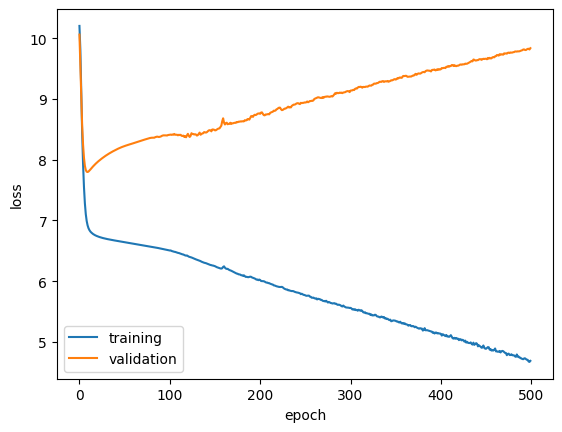

In [9]:
# Training hyperparameters; you are welcome to change these.
# In my experiments, it can take ~500 epochs over the dataset
#   of 1000 training examples before it perfectly
#   translates the training examples.

ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 500
CLIP = 1
LR = 0.0001
USE_LSTM = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###  Don't change code below this line
###  =================================

INPUT_DIM = tr_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
TRG_PAD_IDX = 0

# initialize encoder-decoder model
if USE_LSTM:
    enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = LSTMTranslator(enc, dec, device)
else:
    enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = RNNTranslator(enc, dec, device)

# initialize model weights
def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

# parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

# optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# track training and validation losses
training_loss = []
validation_loss = []

def train(model, iterator, optimizer, criterion, clip, verbose=False):

    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):

        (src, trg) = batch

        optimizer.zero_grad()
        output = model(src, trg)

        # Every so often, print out how well we're doing.
        if verbose and i == 0:
            print(en_tokenizer.decode(trg[0, 1:]))
            en_tokens = output[0, :, :].argmax(1)
            print(en_tokenizer.decode(en_tokens))

        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            (src, trg) = batch

            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]

            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

start_time = time.time()
for epoch in range(N_EPOCHS):

    verbose = (epoch == 0 or N_EPOCHS <= 10
               or (epoch + 1) % (N_EPOCHS // 10) == 0)

    train_loss = train(model, batched_train, optimizer,
                       criterion, CLIP, verbose=verbose)
    valid_loss = evaluate(model, batched_test, criterion)

    training_loss.append(train_loss)
    validation_loss.append(valid_loss)

    # Every so often, print some details on how we're doing.
    if verbose:
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        start_time = time.time()

# At the end, enerate loss plot
import matplotlib.pyplot as plt
plt.plot(training_loss, label="training")
plt.plot(validation_loss, label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

The model has 17,102,660 trainable parameters
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
deserved deservedolinolinolinolinolinolinolinolinolinolinolinolinolinolinolinolinolin
Epoch: 01 | Time: 0m 0s
	Train Loss: 9.333
	 Val. Loss: 7.894
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The's to for s for, the. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
Epoch: 50 | Time: 1m 0s
	Train Loss: 5.964
	 Val. Loss: 9.033
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Nearly's be to beisation, [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] the to the the
Epoch: 100 | Time: 1m 1s
	Train Loss: 4.645
	 Val. Loss: 9.933
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
NATO's newrivatisation process in there [SEP] [SEP]. [SEP] [SEP]. [SEP] [SEP].
Epoch: 150 | Time: 0m 59s
	Train Loss: 3.087
	 Val. 

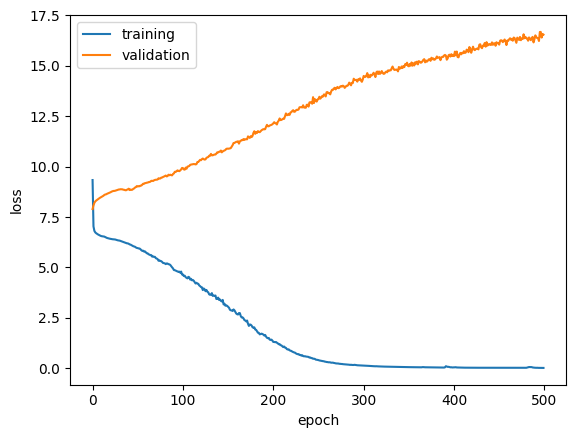

In [12]:
# Training hyperparameters; you are welcome to change these.
# In my experiments, it can take ~500 epochs over the dataset
#   of 1000 training examples before it perfectly
#   translates the training examples.

ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 500
CLIP = 1
LR = 0.001
USE_LSTM = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###  Don't change code below this line
###  =================================

INPUT_DIM = tr_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
TRG_PAD_IDX = 0

# initialize encoder-decoder model
if USE_LSTM:
    enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = LSTMTranslator(enc, dec, device)
else:
    enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = RNNTranslator(enc, dec, device)

# initialize model weights
def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

# parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

# optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# track training and validation losses
training_loss = []
validation_loss = []

def train(model, iterator, optimizer, criterion, clip, verbose=False):

    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):

        (src, trg) = batch

        optimizer.zero_grad()
        output = model(src, trg)

        # Every so often, print out how well we're doing.
        if verbose and i == 0:
            print(en_tokenizer.decode(trg[0, 1:]))
            en_tokens = output[0, :, :].argmax(1)
            print(en_tokenizer.decode(en_tokens))

        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            (src, trg) = batch

            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]

            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

start_time = time.time()
for epoch in range(N_EPOCHS):

    verbose = (epoch == 0 or N_EPOCHS <= 10
               or (epoch + 1) % (N_EPOCHS // 10) == 0)

    train_loss = train(model, batched_train, optimizer,
                       criterion, CLIP, verbose=verbose)
    valid_loss = evaluate(model, batched_test, criterion)

    training_loss.append(train_loss)
    validation_loss.append(valid_loss)

    # Every so often, print some details on how we're doing.
    if verbose:
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        start_time = time.time()

# At the end, enerate loss plot
import matplotlib.pyplot as plt
plt.plot(training_loss, label="training")
plt.plot(validation_loss, label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

The model has 17,102,660 trainable parameters
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
1766 Göttingen Göttingen Göttingenmbergmbergmbergmbergmbergmbergmbergmbergmbergmbergmbergmbergmbergmbergmberg
Epoch: 01 | Time: 0m 0s
	Train Loss: 10.266
	 Val. Loss: 10.248
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The The, the the the the the the the the,,,,,,,,
Epoch: 50 | Time: 0m 51s
	Train Loss: 6.603
	 Val. Loss: 8.311
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The,,, the,,,,,,,,,,,,,,
Epoch: 100 | Time: 0m 39s
	Train Loss: 6.471
	 Val. Loss: 8.548
Kosovo's privatisation process is under scrutiny [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The the the the the the [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
Epoch: 150 | Time: 0m 49s
	Train Loss: 6.310
	 Val. Loss: 8.674
Kosovo's privatisation pr

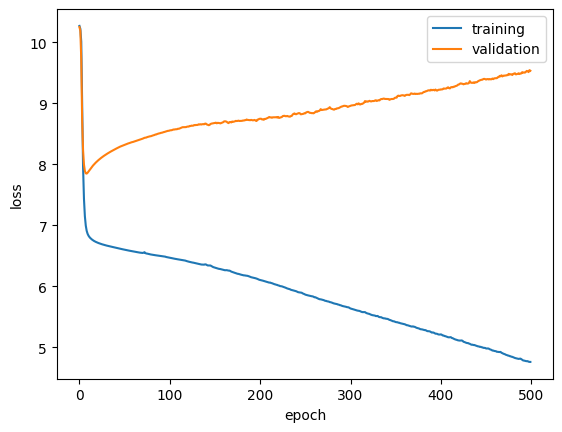

In [10]:
# Training hyperparameters; you are welcome to change these.
# In my experiments, it can take ~500 epochs over the dataset
#   of 1000 training examples before it perfectly
#   translates the training examples.

ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 500
CLIP = 1
LR = 0.0001
USE_LSTM = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###  Don't change code below this line
###  =================================

INPUT_DIM = tr_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
TRG_PAD_IDX = 0

# initialize encoder-decoder model
if USE_LSTM:
    enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = LSTMTranslator(enc, dec, device)
else:
    enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
    dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)
    model = RNNTranslator(enc, dec, device)

# initialize model weights
def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

# parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

# optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# track training and validation losses
training_loss = []
validation_loss = []

def train(model, iterator, optimizer, criterion, clip, verbose=False):

    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):

        (src, trg) = batch

        optimizer.zero_grad()
        output = model(src, trg)

        # Every so often, print out how well we're doing.
        if verbose and i == 0:
            print(en_tokenizer.decode(trg[0, 1:]))
            en_tokens = output[0, :, :].argmax(1)
            print(en_tokenizer.decode(en_tokens))

        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            (src, trg) = batch

            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]

            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

start_time = time.time()
for epoch in range(N_EPOCHS):

    verbose = (epoch == 0 or N_EPOCHS <= 10
               or (epoch + 1) % (N_EPOCHS // 10) == 0)

    train_loss = train(model, batched_train, optimizer,
                       criterion, CLIP, verbose=verbose)
    valid_loss = evaluate(model, batched_test, criterion)

    training_loss.append(train_loss)
    validation_loss.append(valid_loss)

    # Every so often, print some details on how we're doing.
    if verbose:
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        start_time = time.time()

# At the end, enerate loss plot
import matplotlib.pyplot as plt
plt.plot(training_loss, label="training")
plt.plot(validation_loss, label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

<center>
<div style="color:red;background-color:#e5e5e5">(YOUR ANSWER HERE)</div>
.
<div style="color:red;background-color:#e5e5e5">(Don't forget your plots!)</div>
</center>


# 3. Conceptual Questions (4 points)

### 3.1 RNN versus Fully-connected (1.5 points)

Let's compare the number of parameters in an RNN versus in a fully-connected MLP.

Suppose we want a model that can do *binary classification* on sequences, instead of translation. We're given a fixed embedding matrix that maps from our vocabulary of 10,000 tokens to a 100-dimensional vector. Don't count the embedding matrix's parameters in your counts below.

Consider two different models. A visualization of each is provided after the description. In the visualizations, the arrows from the words (e.g., "cat") to the embeddings (e.g., $e_2$) are embedding lookups; remember that you shouldn't count the embedding matrix's parameters in your counts. All other arrows represent some sort of matrix multiplication (which you can assume includes a bias term). You can assume that the final output vector has two dimensions (for the probability of each class).

1. A MLP with two hidden fully-connected layers with 256 hidden nodes each followed by a final fully-connected layer for binary classification.
<center>
<img width="500px" src="https://raw.githubusercontent.com/cs449s23/lectures/cfc1b469e2d26e9811ff87d56682d5b65dfb941a/static/hw4_mlp.png">
</center>

.

2. A torch.nn.RNN like the one you used above, with two hidden layers, a hidden size of 256, and a final fully-connected layer that outputs a binary classification.
<center>
<img width="500px" src="https://raw.githubusercontent.com/cs449s23/lectures/cfc1b469e2d26e9811ff87d56682d5b65dfb941a/static/hw4_rnn.png">
</center>

Answer the following three questions:

* (a.) Let's assume that all sequences are exactly 10 tokens long. To the nearest thousand parameters, how many parameters in total do the MLP and RNN each have?
* (b.) Suppose instead that all sequences are exactly 40 tokens long. Now, to the nearest thousand parameters, how many parameters in total does each model have?
* (c.) What does this say about when you might prefer an RNN or an MLP?

<center>
<div style="color:red;background-color:#e5e5e5">

(a)

For MLP, input to first layer: 10* 100*256 + 256

first layer to second layer: 256*256 + 256

second layer to fc layer: 256*2 + 2

Total number of parameters is 322562, about 300k

For RNN, input to first layer: 100*256 + 256 *256 + 256

first layer to second layer: 256*256 + 256 *256 + 256

second layer to fc layer: 256*2 + 2

Total number of parameters is 223234, about 200k

(b)

For MLP, input to first layer: 40* 100*256 + 256

first layer to second layer: 256*256 + 256

second layer to fc layer: 256*2 + 2

Total number of parameters is 1090562, about 1000k

For RNN, input to first layer: 100*256 + 256 *256 + 256

first layer to second layer: 256*256 + 256 *256 + 256

second layer to fc layer: 256*2 + 2

Total number of parameters is 223234, about 200k

(c)

I would prefer RNN since the number of parameters of RNN is invariant with length of inputs. Thus it can remain at a small number.

</div>
</center>


### 3.2 RNNs versus Transformers (1.5 points)

Suppose you wanted to implement a `TransformerTranslator` model like the ones you implemented above with RNNs or LSTMs. Let's assume you wanted to maintain a similar Encoder and Decoder structure. Answer the following questions:

* (a.) What would be one theoretical advantage of using Transformer models over LSTMs?
* (b.) What would be one theoretical advantage of using LSTMs over Transformers?
* (c.) Consider the input tensors and their shapes that are passed into `self.encoder()` and `self.decoder()` inside of the `LSTMTranslator` class. If your encoder and decoder were both Transformer models, what inputs would they take? Why?

<center>
<div style="color:red;background-color:#e5e5e5">

(a) The self-attention and positional encoding mechanisms inside the transformer can benifit the long-range dependency, thus achieving better results.

(b) LSTM has a smaller number of parameters, thus being able to achieve good performance even with a small dataset.

(c) Besides the embedding, the positional encoding should be added to the inputs, which is an important part of the transformer model.

</div>
</center>


### 3.3 Teacher forcing (1 point)

In the code we provide, there is a hyperparameter for "teacher-forcing" which you can read more about here: https://en.wikipedia.org/wiki/Teacher_forcing

Then, answer the following questions:

* (a.) Why is it important that we set the probability of teacher forcing to 0% at test time?
* (b.) Under what circumstances might you want to have a higher probability during training time? A lower probability? Why?

<center>
<div style="color:red;background-color:#e5e5e5">

(a) At test time, the model should have zero knowledge of the ground truth, thus reflecting the true performance of the model.

(b) Higher: At the beginning stage of the model training or the task is difficult. In these scenarios, the model is hard to converge, and the teacher forcing is needed to help it correct errors more efficiently and coverge faster and better.

Lower: At the later stage of the model training or the task is easy. In these scenarios, the model can be trained without too much supervision. If probability is high, the model may overfit.

</div>
</center>
